In [5]:
import os
import numpy as np
import tensorflow as tf
import librosa
import math
import pyaudio
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mel Frequency Cepstral Coefficients (MFCC)
def extract_mfcc(y, sr):
  mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr, n_mels=128, n_mfcc=12, n_fft=512, hop_length=128))
  return mfcc

def extract_melspectrogram(y, sr):
  melspectrogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
  return melspectrogram

def extract_chroma_vector(y, sr):
  chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
  return chroma

def extract_spectral_contrast(y, sr):
  tonnetz = np.array(librosa.feature.spectral_contrast(y=y, sr=sr))
  return tonnetz

# tonal centroid features (tonnetz)
def extract_tonnetz(y, sr):
  tonnetz = np.array(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr))
  return tonnetz

def extract_features(y, sr):
  # Extracting MFCC feature
  mfcc = extract_mfcc(y, sr)
  mfcc_mean = mfcc.mean(axis=1)
  mfcc_min = mfcc.min(axis=1)
  mfcc_max = mfcc.max(axis=1)
  mfcc_feature = np.concatenate( (mfcc_mean, mfcc_min, mfcc_max) )

  # # Extracting Mel Spectrogram feature
  # melspectrogram = extract_melspectrogram(y, sr)
  # melspectrogram_mean = melspectrogram.mean(axis=1)
  # melspectrogram_min = melspectrogram.min(axis=1)
  # melspectrogram_max = melspectrogram.max(axis=1)
  # melspectrogram_feature = np.concatenate( (melspectrogram_mean, melspectrogram_min, melspectrogram_max) )

  # # Extracting chroma vector feature
  # chroma = extract_chroma_vector(y, sr)
  # chroma_mean = chroma.mean(axis=1)
  # chroma_min = chroma.min(axis=1)
  # chroma_max = chroma.max(axis=1)
  # chroma_feature = np.concatenate( (chroma_mean, chroma_min, chroma_max) )

  # # Extracting spectral contrast feature
  # spectral_contrast = extract_spectral_contrast(y, sr)
  # spectral_contrast_mean = spectral_contrast.mean(axis=1)
  # spectral_contrast_min = spectral_contrast.min(axis=1)
  # spectral_contrast_max = spectral_contrast.max(axis=1)
  # spectral_contrast_feature = np.concatenate( (spectral_contrast_mean, spectral_contrast_min, spectral_contrast_max) )

  # # Extracting tonnetz feature
  # tonnetz = extract_tonnetz(y, sr)
  # tonnetz_mean = tonnetz.mean(axis=1)
  # tonnetz_min = tonnetz.min(axis=1)
  # tonnetz_max = tonnetz.max(axis=1)
  # tonnetz_feature = np.concatenate( (tonnetz_mean, tonnetz_min, tonnetz_max) ) 
  
  # features = np.concatenate( (melspectrogram_feature, mfcc_feature, chroma_feature, spectral_contrast_feature, tonnetz_feature) )
  features = mfcc_feature 
  return features

In [20]:
# for i in range(1,11):
#   file_path = f"./training_data/parker/recording_{i}.m4a"


#   mfcc = extract_mfcc(y, sr)
#   pyplot.imshow(mfcc, interpolation='nearest', aspect='auto')
#   pyplot.title("mfcc\n" + file_path)
#   pyplot.show()

#   melspectrogram = extract_melspectrogram(y, sr)
#   pyplot.imshow(melspectrogram, interpolation='nearest', aspect='auto')
#   pyplot.title("melspectrogram\n" + file_path)
#   pyplot.show()

#   chroma_vector = extract_chroma_vector(y, sr)
#   pyplot.imshow(chroma_vector, interpolation='nearest', aspect='auto')
#   pyplot.title("chroma_vector\n" + file_path)
#   pyplot.show()

#   spectral_contrast = extract_spectral_contrast(y, sr)
#   pyplot.imshow(chroma_vector, interpolation='nearest', aspect='auto')
#   pyplot.title("spectral_contrast\n" + file_path)
#   pyplot.show()

#   tonnetz = extract_tonnetz(y, sr)
#   pyplot.imshow(tonnetz, interpolation='nearest', aspect='auto')
#   pyplot.title("tonnetz\n" + file_path)
#   pyplot.show()


directory = "training_data_wav"
speakers = os.listdir(directory)
features = []
labels = []
for speaker in speakers:
    print("=================================| Extracting features for speaker: " + speaker + " |=================================")
    for file in os.listdir(directory + "/" + speaker):
        file_path = directory + "/" + speaker + "/" + file
        print("[" + file_path + "]\n Splitting up audio and extracting features", end="")
        
        sr = librosa.get_samplerate(file_path)
        stream = librosa.stream(file_path, # 2 seconds
                            block_length=1, #frames in each iteration
                            frame_length=int(sr*0.04), #samples per frame
                            hop_length=int(sr*0.04)) #"hops" -frames will overlap if hop_length < frame_length
        
        label = speakers.index(speaker)
        
        for y in stream:
            #print(".", end="")
            y = (y - min(y)) / (np.max(y) - np.min(y))
            features.append(extract_features(y, sr))
            labels.append(label)
            
        print(" Done!\n")


=================================| Extracting features for speaker: adam |=================================
[training_data_wav/adam/recording_1.wav]
 Splitting up audio and extracting features Done!

=================================| Extracting features for speaker: aiden |=================================
[training_data_wav/aiden/recording_1.wav]
 Splitting up audio and extracting features Done!

=================================| Extracting features for speaker: hannah |=================================
[training_data_wav/hannah/han_rec_1.wav]
 Splitting up audio and extracting features Done!

[training_data_wav/hannah/han_rec_2.wav]
 Splitting up audio and extracting features Done!

=================================| Extracting features for speaker: parker |=================================
[training_data_wav/parker/recording_1.wav]
 Splitting up audio and extracting features Done!

[training_data_wav/parker/recording_11.wav]
 Splitting up audio and extracting features Done!

[trai

In [21]:
num_audio_samples = len(features)
num_classes = len(speakers)

# one hot encode our labels
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

# randomize our data each time so we aren't training on the exact same set of data
permutations = np.random.permutation(num_audio_samples)
features = np.array(features)[permutations]
labels_one_hot = np.array(labels_one_hot)[permutations]

# data splits
train_split = 0.8
test_split = 0.1
val_split = 0.1

if train_split + test_split + val_split != 1.0:
  raise ValueError("test, train and validation splits should sum to 1.0 (100%)")

# split our data using numpy split. by giving two indices the data is split three ways:
#  - everything before index 1 will be our training data
#  - everything after index 1 and until index 2 will be our test data
#  - everything after index 2 will be our validation data
features_train, features_test, features_val = np.split(features, [int(num_audio_samples * train_split), int(num_audio_samples * (train_split + test_split))])
labels_train, labels_test, labels_val = np.split(labels_one_hot, [int(num_audio_samples * train_split), int(num_audio_samples * (train_split + test_split))])

Display the amounts of each class to see if we have roughly the same amount of data for each.

In [22]:
_, class_counts = np.unique(labels, return_counts=True)

print(class_counts)
print("Class Counts:")
for i in range(len(speakers)):
  print(f"{speakers[i]} - {class_counts[i]}")
print("\nmin - " + str(np.min(class_counts)))
print("max - " + str(np.max(class_counts)))
print("standard deviation - " + str(np.std(class_counts)))


[16406 15886 22839 19753]
Class Counts:
adam - 16406
aiden - 15886
hannah - 22839
parker - 19753

min - 15886
max - 22839
standard deviation - 2802.6504419923654


In [23]:
print(features_train.shape)
print(labels_train.shape)

BATCH_SIZE = 32
EPOCHS = 100

model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(features_train.shape[1], input_shape=(features_train.shape[1],), activation = "relu"))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(256, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.25))  

model.add(tf.keras.layers.Dense(128, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.25))  

model.add(tf.keras.layers.Dense(64, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.5))  
  

model.add(tf.keras.layers.Dense(num_classes, activation = "softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()



(59907, 36)
(59907, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36)                1332      
                                                                 
 dropout (Dropout)           (None, 36)                0         
                                                                 
 dense_1 (Dense)             (None, 256)               9472      
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (Non

In [24]:

# Reduce learning rate when a metric has stopped improving
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                 patience=4, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve, stop learning
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                          patience=5, 
                          verbose=2)


history = model.fit(features_train, labels_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    validation_data=(features_val, labels_val),
                    callbacks=[
                      lr_reduction, 
                      estopping
                    ])

Epoch 1/100
1873/1873 [==============================] - 10s 4ms/step - loss: 1.4916 - accuracy: 0.4539 - val_loss: 0.7840 - val_accuracy: 0.5634 - lr: 0.0010
Epoch 2/100
1873/1873 [==============================] - 6s 3ms/step - loss: 0.7446 - accuracy: 0.6240 - val_loss: 0.5817 - val_accuracy: 0.7212 - lr: 0.0010
Epoch 3/100
1873/1873 [==============================] - 4s 2ms/step - loss: 0.5833 - accuracy: 0.7411 - val_loss: 0.4208 - val_accuracy: 0.8316 - lr: 0.0010
Epoch 4/100
1873/1873 [==============================] - 4s 2ms/step - loss: 0.4848 - accuracy: 0.8065 - val_loss: 0.3754 - val_accuracy: 0.8570 - lr: 0.0010
Epoch 5/100
1873/1873 [==============================] - 5s 2ms/step - loss: 0.4418 - accuracy: 0.8263 - val_loss: 0.3545 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 6/100
1873/1873 [==============================] - 5s 2ms/step - loss: 0.4222 - accuracy: 0.8364 - val_loss: 0.3592 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 7/100
1873/1873 [============================

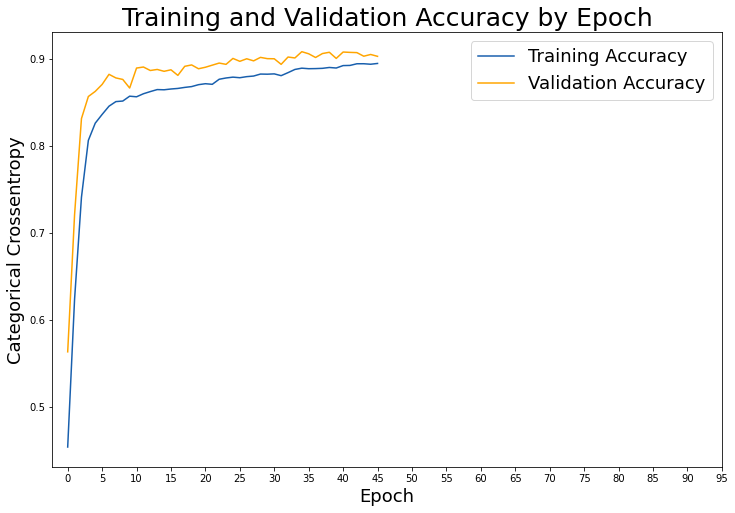

In [25]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,EPOCHS,5), range(0,EPOCHS,5))

plt.legend(fontsize = 18);

In [26]:
# preds = np.argmax(model.predict(features_test), axis=-1)
# print(np.argmax(labels_test, axis=-1))
# print(preds)
score = model.evaluate(x=features_test.tolist(),y=labels_test.tolist(), verbose=1)
print('Accuracy : ' + str(score[1]*100) + '%')

234/234 [==============================] - 0s 1ms/step - loss: 0.2285 - accuracy: 0.9136
Accuracy : 91.35950803756714%


In [ ]:
# # whole file
# y, sr = librosa.load(directory + "/parker/recording_14.wav", offset=0, duration=30)

# frames of a file
test_file_path = "testing_data/adam/jan_17.wav"
sr = librosa.get_samplerate(test_file_path)
stream = librosa.stream(test_file_path,
                    block_length=256,
                    frame_length=2048,
                    hop_length=512)

# microphone input
# sr = 44100
# pa = pyaudio.PyAudio()
# print(pa.get_device_count())
# pa.get_default_output_device_info()
# stream = pa.open(format=pyaudio.paInt16, channels=1, rate=sr, input=True)
# stream = librosa.stream(stream,
#                          block_length=256,
#                          frame_length=2048,
#                          hop_length=2048)

for y in stream:
    test_frame_features = extract_features(y, sr)
    pred = model.predict(test_frame_features.reshape(1,len(test_frame_features)))
    idx = np.argmax(pred)
    print(pred)
    print(idx)
    print(speakers[idx])

In [27]:
from datetime import datetime
time = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
model.save(f"../saved_models/{num_classes}_classes-{time}")

INFO:tensorflow:Assets written to: ../saved_models/4_classes-01_24_2023_14_05_19\assets


INFO:tensorflow:Assets written to: ../saved_models/4_classes-01_24_2023_14_05_19\assets
